# Rendszám felismerő

A következő library-kat használtam a feladat megvalósításához:

In [ ]:
import cv2
import numpy as np
import imutils
import pytesseract as tess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

1. sor: képfeldolgozáshoz 
2. sor: különböző matematikai műveletek elvégzéséhez, kernel előállításához (mátrix műveletek) 
3. sor: a kontúrok, élek megkeresése
4. sor: karakterfelismerés és feldolgozás
5. sor: az eredmények kiíratása
6. sor: ezt a libraryt ahhoz használtam, hogy a plotnál az eredeti színében tudjam kimutatni a képeket

In [ ]:
tess.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

A tesseract modul elérésének útvonala és deklarálása

In [ ]:
kernel = np.ones((1,1),np.uint8)

kepEredeti = mpimg.imread(r"C:\Python\teszt2.jpg")
kep = cv2.imread(r"C:\Python\teszt2.jpg")

kep = cv2.resize(kep, (600,400))                                                        
kepSzurke = cv2.cvtColor(kep, cv2.COLOR_BGR2GRAY)       
kepSzurke = cv2.dilate(kepSzurke, kernel, iterations = 1)
kepSzurke = cv2.bilateralFilter(kepSzurke, 13, 15, 15)

eldetektalt = cv2.Canny(kepSzurke,30,200)                                               # canny eldetektalas (a parameterekkel a tresholdot min,maxot adjuk meg)
kontur = cv2.findContours(eldetektalt.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # a korvonalak megtalalasahoz a hatternek feketenek kell lennie, az el pdig feher ezert, kell a binarys forditas es a canny eldetektalas (kep, a kinyeresi logika, kozelites) )
kontur = imutils.grab_contours(kontur)
kontur = sorted(kontur, key = cv2.contourArea, reverse = True)[:10]


Ebben a részben történik a kép előfeldolgozása. 

Deklaráltam egy kernelt, amit a dilatációhoz fogok használni. Erre azért van szükség, hogy a fehér részek területe kicsit bővüljön.

Beolvasom a képeket. Azért olvastam be két külön változóba, hogy a végén a kiírásnál az eredetit szépen meg tudjam jeleníteni. Amit OpenCV-vel olvastamba azzal fogok dolgozni.

Átméretezem a képet, hogy csökkentsem a hibák lehetőségét.

Történik egy átalakítás színesről "fekete-fehérre", így sokkal több művelet lesz értelmezhető OpenCV-vel, mint színes képeken.

A diletáció, amit már a kernelnél említettem.

BilateralFilter érdekes, mert enélkül volt olyan kép aminél az összekötő "-" helyett "+" olvasott le az algoritmus, így mint további képfeldolgozó bent hagytam.

Canny éldetektálás (min, max) paraméterek beállítása, ezzel is sokat teszteltem, hogy végül kijöjjön a 30,200. Megfelelő kompromisszumnak tűnik, még elég él marad meg, de nagyjából a zavarókat kiiktatja.

Az élek detektálása után letárolom a kontúrokat amihez közelítést végez a program.

A lépések a teljesség igénye nélkül:

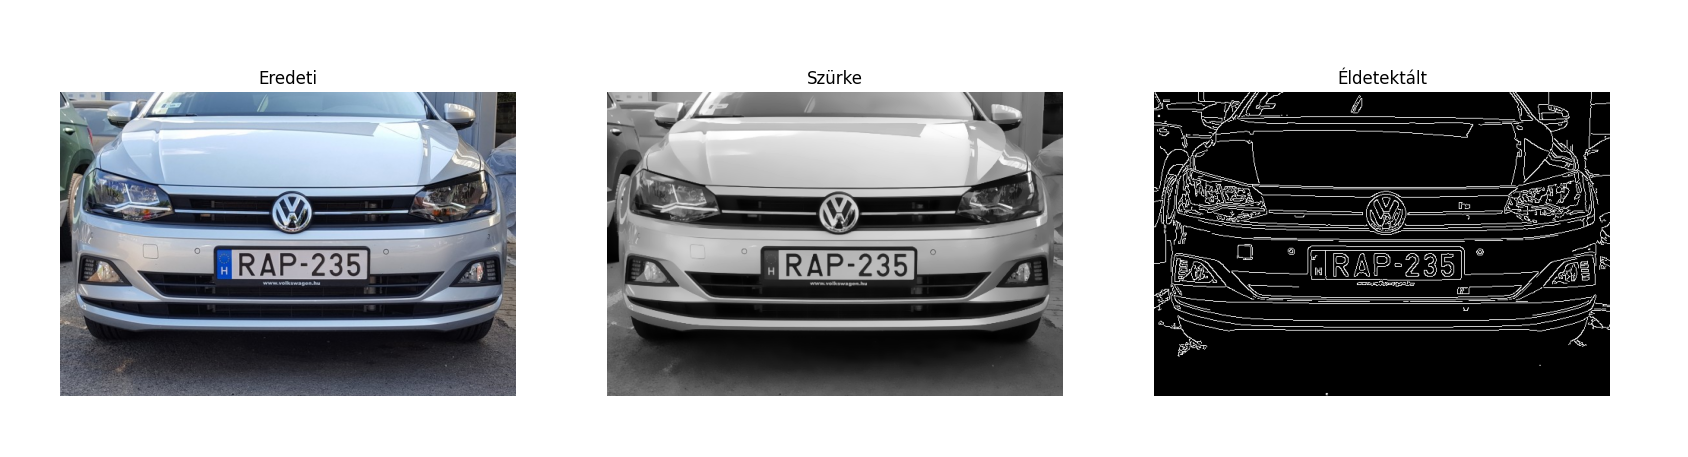

In [ ]:
screenCnt = None

for k in kontur:
    
    peri = cv2.arcLength(k, True)
    kozelites = cv2.approxPolyDP(k, 0.018 * peri, True)
 
    if len(kozelites) == 4:
        screenCnt = kozelites
        break

if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1

if detected == 1:
    cv2.drawContours(kep, [screenCnt], -1, (0, 255, 255), 3)

mask = np.zeros(kepSzurke.shape,np.uint8)
keretezett_rendszam = cv2.drawContours(mask,[screenCnt],0,255,-1,)
keretezett_rendszam = cv2.bitwise_and(kep,kep,mask=mask)

(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
rendszam = kepSzurke[topx:bottomx+1, topy:bottomy+1]

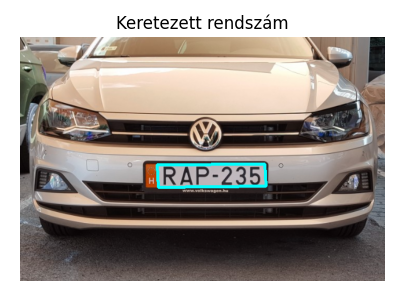

In [ ]:
rendszam = cv2.resize(rendszam,(500,200))

cv2.imwrite(r"C:\Python\rendszam.jpg", rendszam)

rendszam = cv2.imread(r"C:\Python\rendszam.jpg") 
szurke_rendszam = cv2.cvtColor (rendszam, cv2.COLOR_BGR2GRAY)
szurke_rendszam = cv2.GaussianBlur(szurke_rendszam,(5,5),0)                       #a blur miatt pontosabb eredmenyt lehet kapni, az igaz, hogy minel magasabb a blur annal pontosabb, de elveszhetnek fontos infok
binary_rendszam = cv2.threshold(szurke_rendszam, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
binary_rendszam = cv2.morphologyEx(binary_rendszam, cv2.MORPH_OPEN, kernel2, iterations=1)
binary_rendszam = 255 - binary_rendszam

text = tess.image_to_string(binary_rendszam, lang ='eng', config=' --psm 6 ')

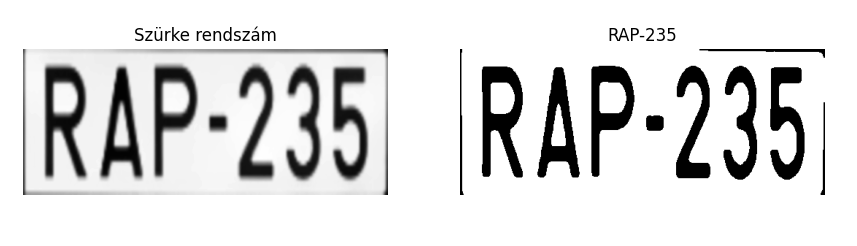

Ismét átméretezem a kivágott rendszám képét, amit le is teszteltem és amikor kihagytam a lépést az output hibás volt.

Átméretezés, utána mentem egy mappába, hogy vissza tudja olvasni OpenCV-vel és a korábbihoz hasonlóan elvégezzük az előfeldolgozást. Annyi különbséggel, hogy itt már csak a rendszámra értelmezem. Végeredményként egy csodás bináris képet kapunk, amit Gauss szűrővel egy kis küszöböléssel és átalakításokkal érek el. Nagyon fontos, ugyanis a tesseract ilyen típusú képen a leghatékonyabb.

Beküldöm a bináris képet a tesseractba amit kiraka text változóba és ha minden összejött megvan a rendszám.

A tesseract paraméterezéséről kicsit, mivel ezzel is sokat kellett tesztelni, hogy mi lehet a megfelelő. Találtam egy nem hivatalos leírást arról, hogy milyen módszer alapján szeretnénk a karakterek szegmentálását végrehajtani. 

  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


In [ ]:
utolsoChar = len(text)
text2 = ""
for x in range (utolsoChar-2):
    text2 = text2 + text[x]

print("Rendszam:",text2)

plt.figure(1, figsize=(20, 8))

plt.subplot(131), plt.title("Eredeti"), plt.imshow(kepEredeti), plt.axis("off")
plt.subplot(132), plt.title("Szürke"), plt.imshow(kepSzurke, cmap="gray"), plt.axis("off")
plt.subplot(133), plt.title("Éldetektált"), plt.imshow(eldetektalt, cmap="gray"), plt.axis("off")

plt.figure(2, figsize=(16, 6))

plt.subplot(131), plt.title("Keretezett rendszám"), plt.imshow(kep), plt.axis("off")
plt.subplot(132), plt.title("Szürke rendszám"), plt.imshow(szurke_rendszam, cmap="gray"), plt.axis("off")
plt.subplot(133), plt.title(text2), plt.imshow(binary_rendszam, cmap="gray"), plt.axis("off")

plt.show()

A tesseract az eredmények végére hozzárak egy szóközt illetve egy karaktert, amit a kis for ciklussal leszedek, hogy a kimenet szebb legyen.

A továbbiakban pedig a plotolások kódjai láthatók, ebben nem sok varázslat van.


# A program kimenete:

### Megpróbáltam nagyjából az összes fontos lépést képek formájában is kiemelni, hogy átlátható legyen az elvégzett munka.

### Az utolsó képen illetve a consoleba is kiíratom a rendszámot.

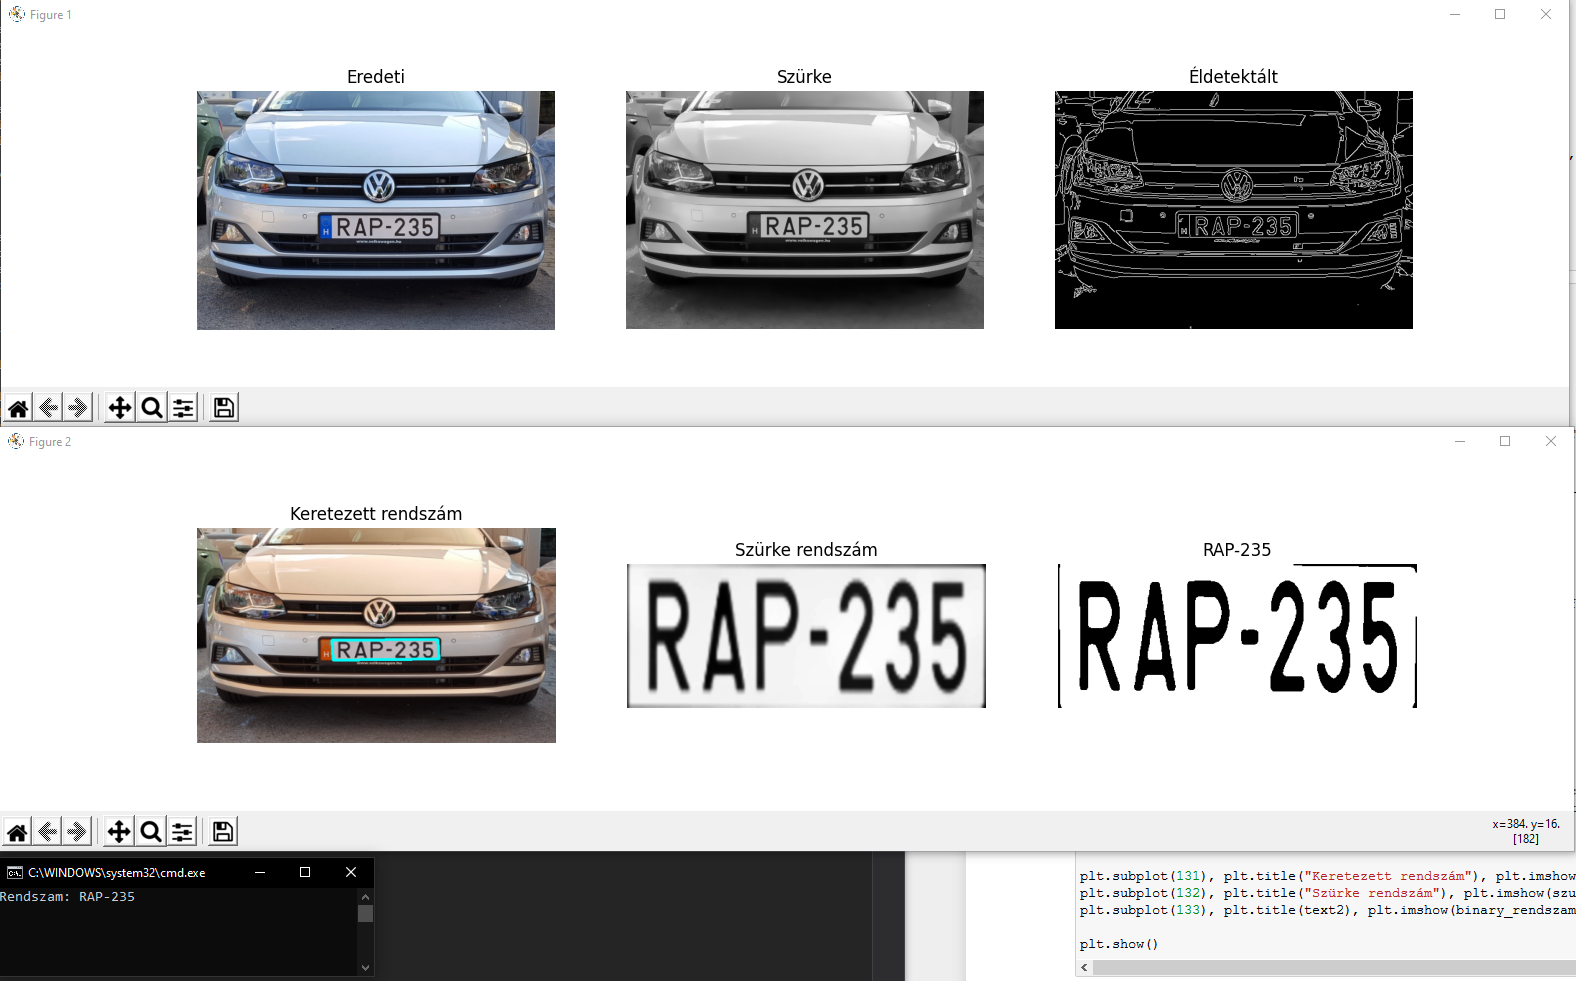

### Még egy kimenet:

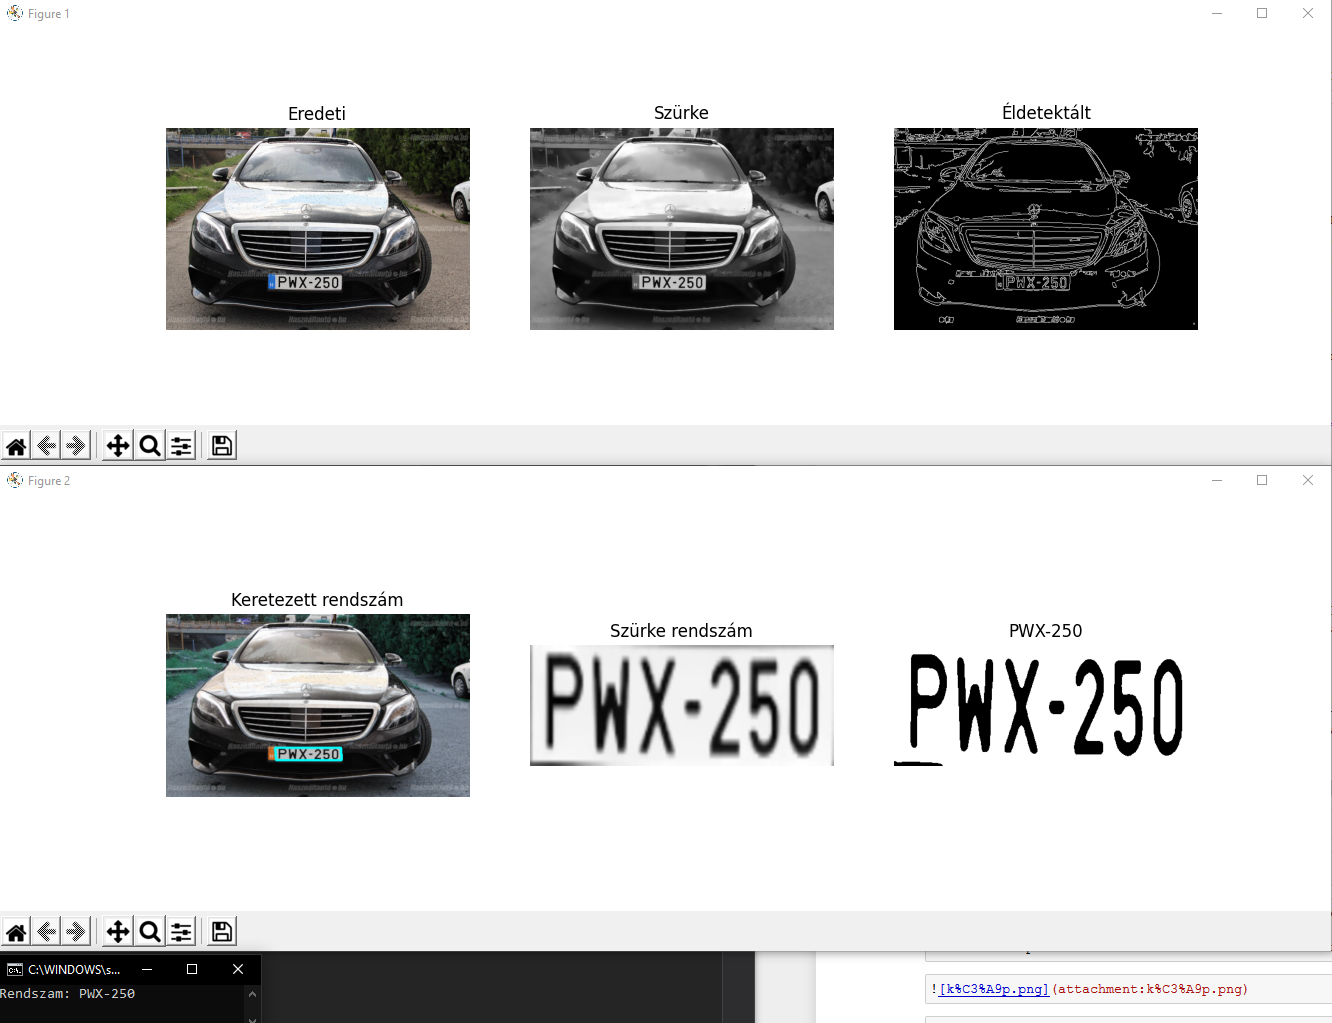

### Illetve egy 3. kimenet: (ami már csak közepesen jó)

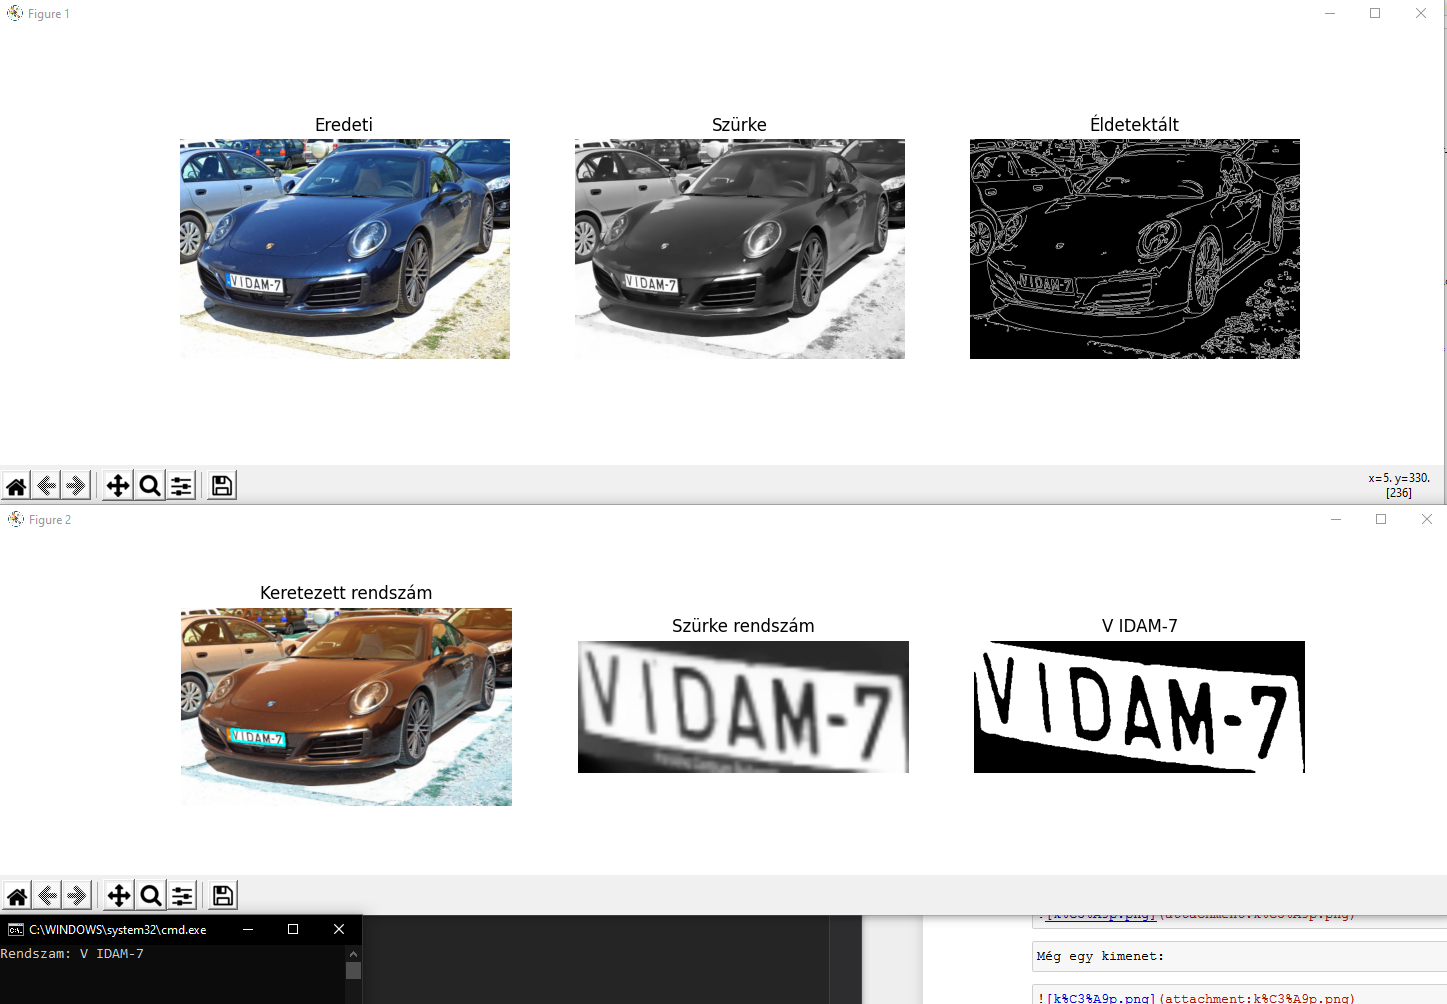

### Természetesen meg lehet fogni a programot, volt hibás kimenettel rendelkező tesztem is, amit valószínűleg további előfeldolgozással lehetne még javítgatni, de alapvetően egész jó eredménynek tűnik.